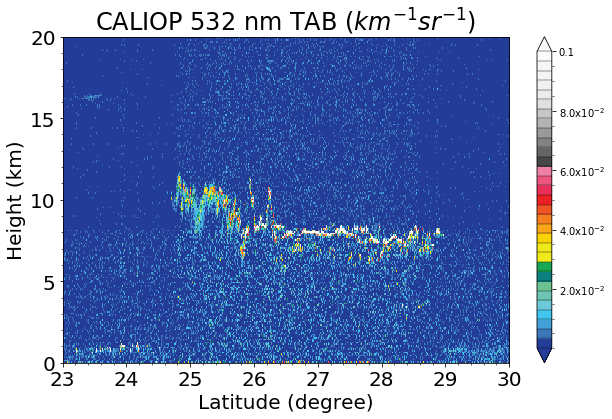

In [3]:
from pyhdf.SD import SD, SDC    # Python interface to the HDF4 library.
from pyhdf.HDF import *
from pyhdf.VS import *
from scipy import interpolate
from matplotlib.colors import ListedColormap
from math import *
import matplotlib.pyplot as plt # Python 2D plotting library.
import matplotlib as mpl
import numpy as np              # Computing with Python.


class SciFormatter(mpl.ticker.Formatter):
    def __call__(self, x, pos=None):
        if x == 0.0: return "0.0"
        y = log(abs(x), 10)
        n = int(floor(y))
        if n < -1 or n > 2: return "%.1fx10$^{%d}$" % (x/10**n, n)
        else: return "%.1f" % (x,)


# font size
plt.rc('font', size=20)


# Visible Minor thick
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True


# ----------------------------------------------------------------
# 1. Read level 1 CALIOP (total attenutated backscatter at 532 nm)
# ----------------------------------------------------------------

# Open hdf file
dir = '/storage1/jhlee/NMSC_2018/Caliop/'
FILE_NAME = dir + 'CAL_LID_L1-Standard-V4-10.2017-11-03T04-35-45ZD.hdf'
#FILE_NAME = dir + 'CAL_LID_L1-Standard-V4-10.2017-11-08T04-53-56ZD.hdf'


# Read SDS datasets
hdf = SD(FILE_NAME, SDC.READ)
data1 = hdf.select('Latitude')
data2 = hdf.select('Total_Attenuated_Backscatter_532')
lat   = data1.get()  # Latitude (x-axis)
lat   = lat[:,0]
TAB_532 = data2.get()  # TAB_532 (y-axis)



# Specific region of CALIOP level 1
latmin = 23. ; latmax = 30.
idx = np.where( (lat >= latmin) & (lat <= latmax) )
TAB_532 = TAB_532[idx,:] # Select specific region
lat = lat[idx]

TAB_532 = TAB_532[0,:,:]



# Backscatter is Valid values?
fill_value = -9999.
TAB_532[ TAB_532 == fill_value] = np.nan



# CALIOP Height
file = dir + 'lidar_altitudes.txt'
hgt = np.genfromtxt(file, dtype=float)



# Designed Height area
hgtmin = 0. ; hgtmax = 20.
idx = np.where( (hgt >= hgtmin) & (hgt <= hgtmax) )
TAB_532 = TAB_532[:,idx]
TAB_532 = TAB_532[:,0,:]
hgt = hgt[idx]



# Interpolate data to the common height grid 'h_interp'
dz = 0.1 
nz = int( (hgtmax-hgtmin)/dz ) + 1
hgt_interp = hgtmin + np.arange(0,201) * dz
hgt_interp = hgt_interp[::-1] 


TAB_532_interp = np.array ([[0. for col in range(nz)] for row in range(len(lat))] )


for i in np.arange(0, len(lat)):
    f = interpolate.interp1d(hgt,TAB_532[i,:], kind='quadratic', fill_value='extrapolate')
    TAB_532_interp[i,:] = f(hgt_interp)


# -------------------------------------
# 2. plot CTHs with respect to latitude
# -------------------------------------

# Load my colortable
cmap = np.genfromtxt('calipso-backscatter.cmap', dtype=int)
my_cmap = ListedColormap(cmap/256., 'my_cmap') # RGB color : 0 to 1


# Plot CALIOP CTHs
plt.figure(figsize=(10,6))

vmin = 1.0e-04 ; vmax = 0.1

ticks1 = list(np.arange(0.0001,0.001,0.0001))
ticks2 = list(np.arange(0.001, 0.0085, 0.0005))
ticks3 = list(np.arange(0.01, 0.11, 0.01))
ticks = ticks1 + ticks2 + ticks3

fig = plt.imshow(TAB_532_interp.T, cmap = my_cmap, interpolation = 'nearest', \
                 aspect = 'auto', vmin = vmin, vmax = vmax, extent = [latmin,latmax,hgtmin,hgtmax])
cbar = plt.colorbar(fig, extend = 'both', format = SciFormatter(), drawedges = True)
cbar.ax.tick_params(labelsize=10) # font size of colorbar
#cbar.minorticks_on() # minor colorbar

plt.xlabel('Latitude (degree)')
plt.ylabel('Height (km)')
plt.yticks(np.arange(hgtmin,hgtmax+1,5))
plt.title('CALIOP 532 nm TAB $(km^{-1}sr^{-1})$')
plt.savefig('../plots/CALIOP/CALIOP_TAB532_2017-11-03.png', dpi=300, \
            bbox_inches='tight', pad_inches=0)
plt.show()